# Performance Analysis

Performance analysis of hill climing agents

In [1]:
import os
from glob import glob
import pickle
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline

Load pickled data

In [2]:
data_dir = "../src/runs/"

In [3]:
def latest_run(data_dir, agent):
    dirnames = glob('{}/{}/*'.format(data_dir, agent))
    idx = np.argmax([dirname.split('/')[-1] for dirname in dirnames])
    return dirnames[idx]

In [4]:
latest_vanilla = latest_run(data_dir, 'vanilla')
print(latest_vanilla)

../src/runs//vanilla/20181015180710


In [5]:
pkl_filename = '{}/data.pkl'.format(latest_vanilla)
os.path.exists(pkl_filename)

True

In [6]:
data = pickle.load(open(pkl_filename, 'rb'))

Review whats inside data

In [7]:
data['args']

Namespace(env='CartPole-v0', episodes=1000, gamma=1.0, goal=200, policy='vanilla', runs=1000, steps=1000)

In [8]:
all_rewards = data['all_rewards']

In [9]:
len(all_rewards)

1000

In [10]:
print(len(all_rewards[0]))
print(len(all_rewards[10]))
print(len(all_rewards[100]))

216
1
230


Lets us pandas to get stats and help with plotting

In [11]:
solved_per_run = {run:len(episodes) for run, episodes in all_rewards.items()}

In [12]:
df = pd.DataFrame.from_dict({'runs': list(solved_per_run.keys()), 'episodes': list(solved_per_run.values())})
df.head()

,runs,episodes
0,0,216
1,1,217
2,2,216
3,3,1
4,4,1


In [13]:
df.describe()

,runs,episodes
count,1000.000000,1000.000
mean,499.500000,367.374
std,288.819436,399.116
min,0.000000,1.000
25%,249.750000,1.000
50%,499.500000,217.000
75%,749.250000,912.000
max,999.000000,1000.000


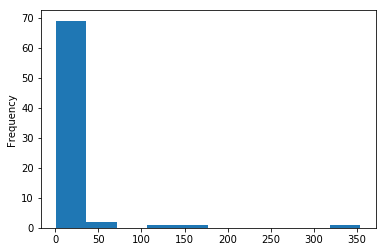

In [14]:
df['episodes'].value_counts().plot(kind='hist')

Very skewed histogram, perhaps we can do better by using log scale

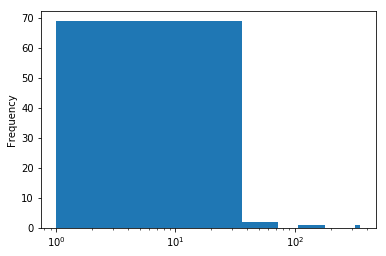

In [15]:
df['episodes'].value_counts().plot(kind='hist', logx=True)

Well, it isn't really helpful because we need to see the episodes too.

We are going to use altair to get interactive plots

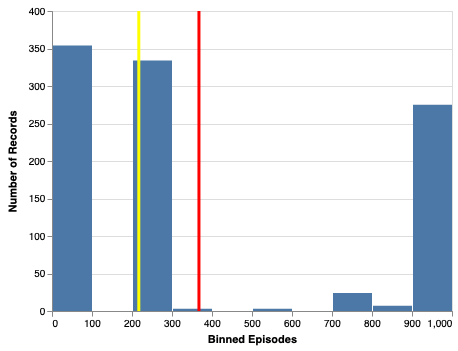

In [16]:
bar = alt.Chart(df).mark_bar().encode(
    alt.X("episodes", bin=True, title="Binned Episodes"),
    alt.Y("count(episodes)"),
#     alt.Color("count(episodes)", scale=alt.Scale(scheme="oranges"))
)

rule = alt.Chart(df).mark_rule(color='red').encode(
    x='mean(episodes)',
    size=alt.value(3)
)

rule2 = alt.Chart(df).mark_rule(color='yellow').encode(
    x='median(episodes)',
    size=alt.value(3)
)

#bar
bar + rule + rule2

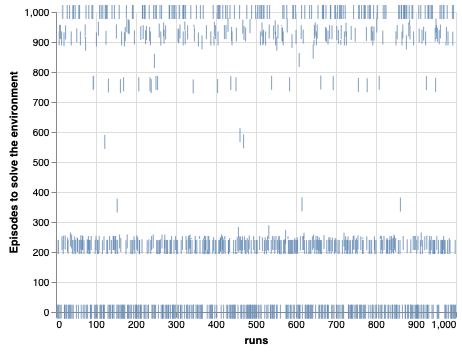

In [17]:
ticks_chart = alt.Chart(df).mark_tick().encode(
    alt.Y("episodes", title="Episodes to solve the environment"),
    alt.X("runs"),
    tooltip = ["episodes", 'runs']
#     alt.Color("count(episodes)", scale=alt.Scale(scheme="oranges"))
).properties(
    width=400,
    height=300
)
ticks_chart

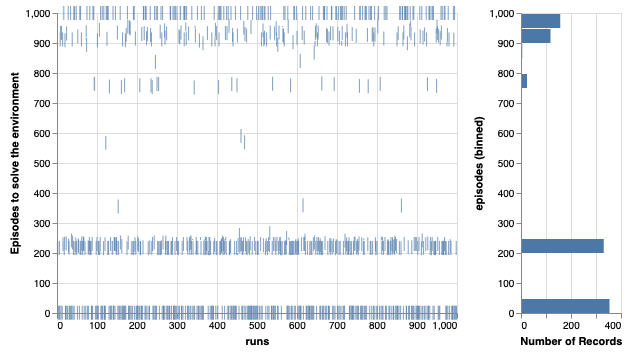

In [18]:
chart2 = alt.Chart(df).mark_bar().encode(
    x='count()',
    y=alt.Y('episodes:Q', bin=alt.Bin(maxbins=30)),
).properties(
    width=100,
    height=300
)

ticks_chart | chart2


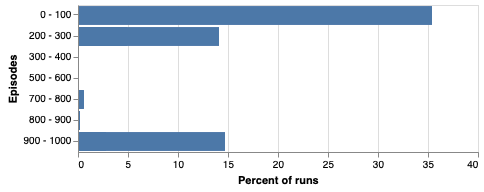

In [19]:
temp_df = df.groupby(['episodes']).agg('count')
temp_df.columns = ['run_count']
temp_df['run_count_pct'] = temp_df.run_count.apply(lambda x: 100 * x/float(temp_df.run_count.sum()))

alt.Chart(temp_df.reset_index()).mark_bar().encode(
    alt.Y('episodes:N', bin=alt.Bin(maxbins=10), title='Episodes'),
    alt.X('run_count_pct', title='Percent of runs')
)

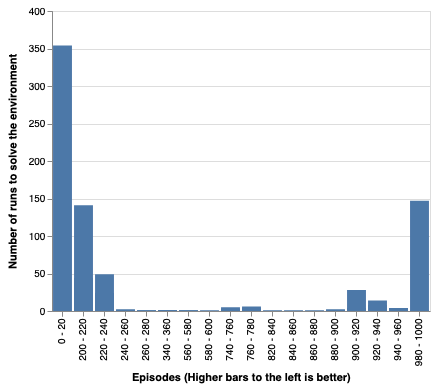

In [20]:
temp_df = df.groupby(['episodes']).agg('count')
temp_df.columns = ['run_count']
temp_df
alt.Chart(temp_df.reset_index()).mark_bar().encode(
    alt.X('episodes:N', bin=alt.Bin(maxbins=50), title='Episodes (Higher bars to the left is better)'),
    alt.Y('run_count', title='Number of runs to solve the environment')
)

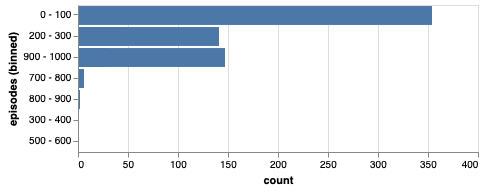

In [21]:
alt.Chart(df).mark_point().transform_aggregate(
    count = 'count()',
    groupby=['episodes']
).transform_window(
    rank='rank(count)',
    sort=[alt.SortField('count', order='descending')]    
).mark_bar().encode(
    alt.Y('episodes:N', bin=alt.Bin(step=100), sort=alt.EncodingSortField(field='count', op='sum', order='descending')),
    alt.X('count:Q')
)

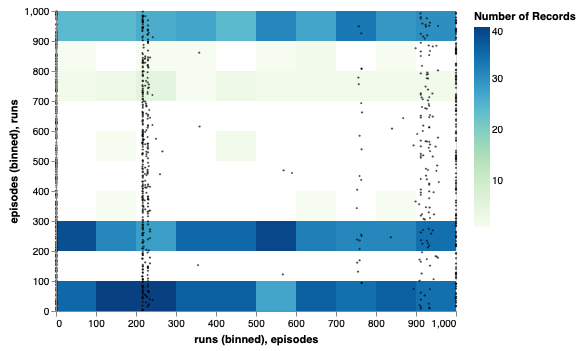

In [22]:
rect = alt.Chart(df).mark_rect().encode(
    alt.Y('episodes:Q', bin=alt.Bin(maxbins=10)),
    alt.X('runs:Q', bin=alt.Bin(maxbins=10)),
    alt.Color('count(runs)', scale=alt.Scale(scheme='greenblue'))
)
# rect
points = alt.Chart(df).mark_circle(
    color='black',
    size=5,
).encode(
    x='episodes:Q',
    y='runs:Q',
)

rect + points


Okay, thats better. Next, we can create helper functions to read data for each policy and generate plots

In [23]:
def plot_altair(df, title=""):
    bar = alt.Chart(df).mark_bar().encode(
        alt.X("episodes", bin=True, title="Binned Episodes"),
        alt.Y("count(episodes)"),
    #     alt.Color("count(episodes)", scale=alt.Scale(scheme="oranges"))
    ).properties(
        title=title
    )

    rule = alt.Chart(df).mark_rule(color='red').encode(
        x='mean(episodes)',
        size=alt.value(3)
    )
    #bar
    return bar + rule    

In [24]:
def plot_altair2(df, title=""):
    temp_df = df.groupby(['episodes']).agg('count')
    temp_df.columns = ['run_count']
    chart = alt.Chart(temp_df.reset_index()).mark_bar().encode(
        alt.X('episodes:N', bin=alt.Bin(step=100), title='Binned Episodes'),
        alt.Y('run_count', title='Number of runs')
    ).properties(
        title=title
    )
    return chart

In [25]:
def plot_altair_ticks(df, title=""):
    chart1 = alt.Chart(df).mark_tick().encode(
        alt.Y("episodes", title="Episodes to solve the environment"),
        alt.X("runs", title="Number of runs"),
        tooltip = ["episodes", 'runs']
    ).properties(
        title=title,
        width=400,
        height=300        
    )

    chart2 = alt.Chart(df).mark_bar().encode(
        x='count()',
        y=alt.Y('episodes:Q', bin=alt.Bin(maxbins=30)),
    ).properties(
        width=100,
        height=300
    )

    return chart1 | chart2

In [101]:
def plot(data_dir, agent, altair=False, title=""):
    latest_dirname = latest_run(data_dir, agent)
    pkl_filename = '{}/data.pkl'.format(latest_dirname)
    print('using pickle path: {}'.format(pkl_filename))
    data = pickle.load(open(pkl_filename, 'rb'))
    solved_per_run = {run:len(episodes) for run, episodes in data['all_rewards'].items()}
    df = pd.DataFrame.from_dict({'runs': list(solved_per_run.keys()), 'episodes': list(solved_per_run.values())})
    print(df.describe())
#     return df.plot(x='runs', y='episodes', kind='hist')
    if altair:
        chart = plot_altair(df, title) 
#         chart = plot_altair2(df, title) #added 23nov18
#         chart = plot_altair_ticks(df, title) #added 23nov18    
    else:
        chart = df['episodes'].value_counts().plot(kind='hist', bins=20)
        chart.set_xlabel('Episodes required to solve the environment')
        
    return chart, df

# Random Policy

using pickle path: ../src/runs//random/20181018190608/data.pkl
              runs     episodes
count  1000.000000  1000.000000
mean    499.500000   660.340000
std     288.819436   473.471858
min       0.000000     1.000000
25%     249.750000     1.000000
50%     499.500000  1000.000000
75%     749.250000  1000.000000
max     999.000000  1000.000000


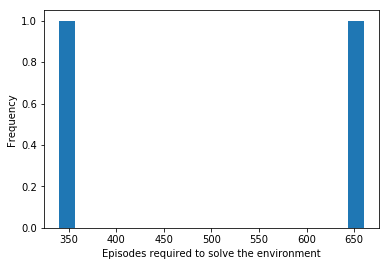

In [27]:
chart, random_df = plot(data_dir, "random")
chart

using pickle path: ../src/runs//random/20181018190608/data.pkl
              runs     episodes
count  1000.000000  1000.000000
mean    499.500000   660.340000
std     288.819436   473.471858
min       0.000000     1.000000
25%     249.750000     1.000000
50%     499.500000  1000.000000
75%     749.250000  1000.000000
max     999.000000  1000.000000


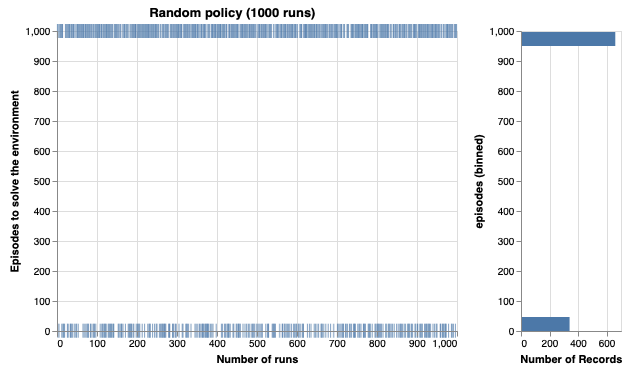

In [52]:
chart, random_df = plot(data_dir, "random", altair=True, title= "Random policy (1000 runs)")
chart

In [53]:
# chart.save('random.svg')
chart.save('plots/random.png')

# Vanilla Hill Climbing

using pickle path: ../src/runs//vanilla/20181015180710/data.pkl
              runs  episodes
count  1000.000000  1000.000
mean    499.500000   367.374
std     288.819436   399.116
min       0.000000     1.000
25%     249.750000     1.000
50%     499.500000   217.000
75%     749.250000   912.000
max     999.000000  1000.000


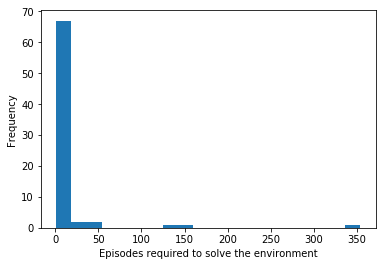

In [54]:
chart, vanilla_df = plot(data_dir, 'vanilla')
chart

using pickle path: ../src/runs//vanilla/20181015180710/data.pkl
              runs  episodes
count  1000.000000  1000.000
mean    499.500000   367.374
std     288.819436   399.116
min       0.000000     1.000
25%     249.750000     1.000
50%     499.500000   217.000
75%     749.250000   912.000
max     999.000000  1000.000


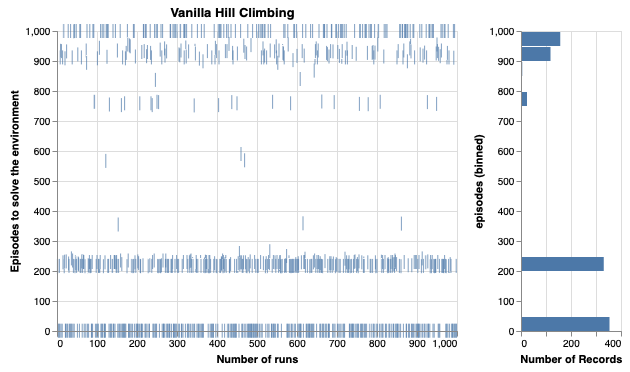

In [55]:
chart, vanilla_df = plot(data_dir, 'vanilla', altair=True, title="Vanilla Hill Climbing")
chart

In [56]:
# chart.save('vanilla.svg')
chart.save('plots/vanilla.png')

# Steepest Ascend

using pickle path: ../src/runs//steepest/20181015182144/data.pkl
              runs     episodes
count  1000.000000  1000.000000
mean    499.500000    73.383000
std     288.819436    53.217821
min       0.000000     1.000000
25%     249.750000     1.000000
50%     499.500000   103.000000
75%     749.250000   103.000000
max     999.000000   418.000000


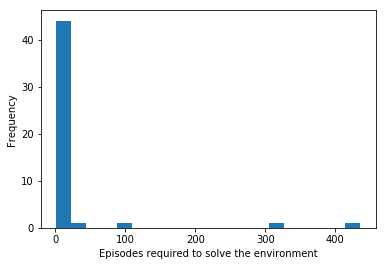

In [57]:
chart, steepest_df = plot(data_dir, 'steepest')
chart

using pickle path: ../src/runs//steepest/20181015182144/data.pkl
              runs     episodes
count  1000.000000  1000.000000
mean    499.500000    73.383000
std     288.819436    53.217821
min       0.000000     1.000000
25%     249.750000     1.000000
50%     499.500000   103.000000
75%     749.250000   103.000000
max     999.000000   418.000000


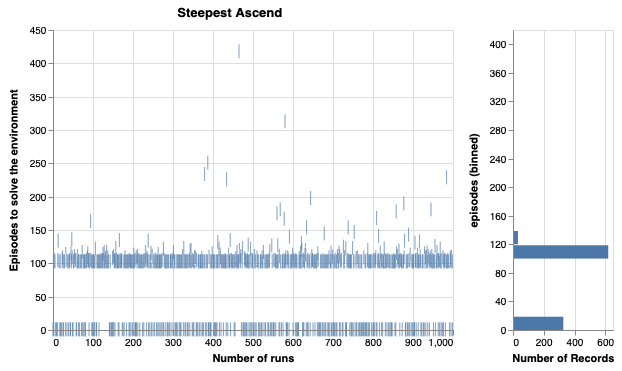

In [58]:
chart, steepest_df = plot(data_dir, 'steepest', altair=True, title="Steepest Ascend")
chart

In [59]:
# chart.save('steepest.svg')
chart.save('plots/steepest.png')

# Simulated annealing

using pickle path: ../src/runs//anneal/20181015200209/data.pkl
              runs    episodes
count  1000.000000  1000.00000
mean    499.500000   366.85900
std     288.819436   380.82428
min       0.000000     1.00000
25%     249.750000     1.00000
50%     499.500000   217.00000
75%     749.250000   912.00000
max     999.000000  1000.00000


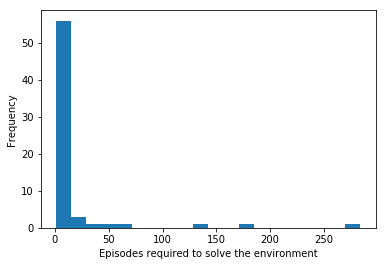

In [102]:
chart, anneal_df = plot(data_dir, 'anneal')
chart

using pickle path: ../src/runs//anneal/20181015200209/data.pkl
              runs    episodes
count  1000.000000  1000.00000
mean    499.500000   366.85900
std     288.819436   380.82428
min       0.000000     1.00000
25%     249.750000     1.00000
50%     499.500000   217.00000
75%     749.250000   912.00000
max     999.000000  1000.00000


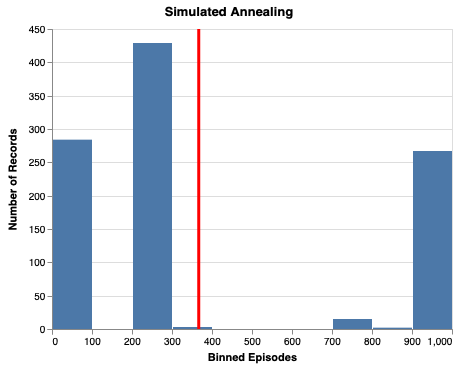

In [103]:
chart, anneal_df = plot(data_dir, 'anneal', altair=True, title="Simulated Annealing")
chart

In [105]:
with open('plots/simulated_annealing.json', 'w') as fp:
    fp.write(chart.to_json())

In [62]:
# chart.save('simanneal.svg')
chart.save('plots/simanneal.png')

# Adaptive noise scaling

using pickle path: ../src/runs//ada/20181018184103/data.pkl
              runs    episodes
count  1000.000000  1000.00000
mean    499.500000   346.61200
std     288.819436   422.69157
min       0.000000     1.00000
25%     249.750000     1.00000
50%     499.500000   118.00000
75%     749.250000  1000.00000
max     999.000000  1000.00000


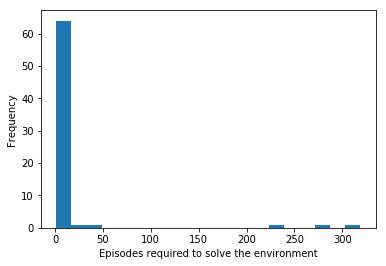

In [63]:
chart, ada_df = plot(data_dir, 'ada')
chart

using pickle path: ../src/runs//ada/20181018184103/data.pkl
              runs    episodes
count  1000.000000  1000.00000
mean    499.500000   346.61200
std     288.819436   422.69157
min       0.000000     1.00000
25%     249.750000     1.00000
50%     499.500000   118.00000
75%     749.250000  1000.00000
max     999.000000  1000.00000


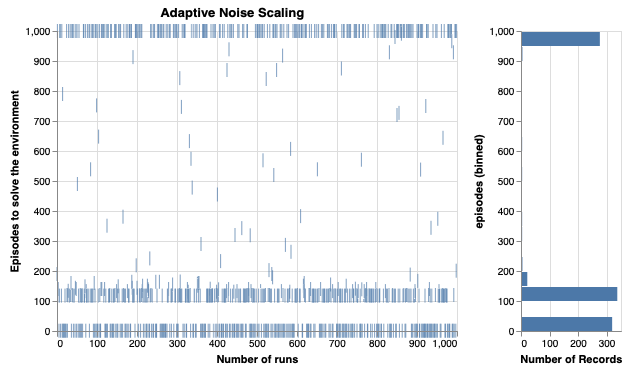

In [64]:
chart, ada_df = plot(data_dir, 'ada', altair=True, title="Adaptive Noise Scaling")
chart

In [65]:
# chart.save('ada.svg')
chart.save('plots/ada.png')

In [73]:
master_df = pd.DataFrame(columns=['algo', 'episodes', 'runs',])
random_df['algo'] = 'Random'
master_df = master_df.append(random_df, ignore_index=True, sort=False)
# Vanilla
vanilla_df['algo'] = 'Vanilla'
master_df = master_df.append(vanilla_df, ignore_index=True, sort=False)
# Steepest
steepest_df['algo'] = 'Steepest Ascend'
master_df = master_df.append(steepest_df, ignore_index=True, sort=False)
# Simulated
anneal_df['algo'] = 'Simulated Annealing'
master_df = master_df.append(anneal_df, ignore_index=True, sort=False)
# Adaptive
ada_df['algo'] = 'Adaptive Noise Scaling'
master_df = master_df.append(ada_df, ignore_index=True, sort=False)

master_df.head()

,algo,episodes,runs
0,Random,1000,0
1,Random,1000,1
2,Random,1,2
3,Random,1000,3
4,Random,1,4


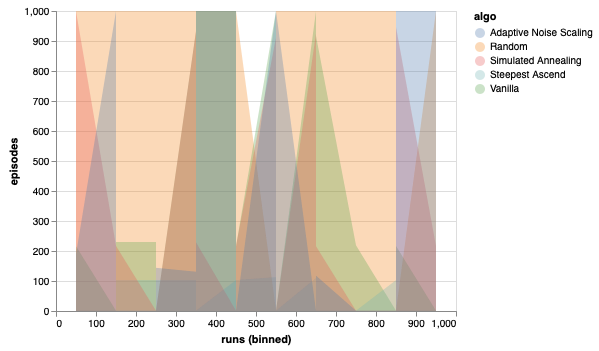

In [76]:
alt.Chart(master_df).mark_area(
    opacity=0.3
).encode(
    alt.X('runs', bin=True),
    alt.Y('episodes'),
    alt.Color('algo')
)

In [77]:
random_series = random_df.episodes.describe()
random_series.name = 'random'
random_series

count    1000.000000
mean      660.340000
std       473.471858
min         1.000000
25%         1.000000
50%      1000.000000
75%      1000.000000
max      1000.000000
Name: random, dtype: float64

In [78]:
all_df = pd.DataFrame(random_series)
all_df.head()

,random
count,1000.000000
mean,660.340000
std,473.471858
min,1.000000
25%,1.000000


In [79]:
vanilla_series = vanilla_df.episodes.describe()
vanilla_series.name = 'vanilla'
vanilla_series

count    1000.000
mean      367.374
std       399.116
min         1.000
25%         1.000
50%       217.000
75%       912.000
max      1000.000
Name: vanilla, dtype: float64

In [80]:
steepest_series = steepest_df.episodes.describe()
steepest_series.name = 'steepest'
steepest_series

count    1000.000000
mean       73.383000
std        53.217821
min         1.000000
25%         1.000000
50%       103.000000
75%       103.000000
max       418.000000
Name: steepest, dtype: float64

In [81]:
anneal_series = anneal_df.episodes.describe()
anneal_series.name = 'anneal'
anneal_series

count    1000.00000
mean      366.85900
std       380.82428
min         1.00000
25%         1.00000
50%       217.00000
75%       912.00000
max      1000.00000
Name: anneal, dtype: float64

In [82]:
ada_series = ada_df.episodes.describe()
ada_series.name = 'adaptive'
ada_series

count    1000.00000
mean      346.61200
std       422.69157
min         1.00000
25%         1.00000
50%       118.00000
75%      1000.00000
max      1000.00000
Name: adaptive, dtype: float64

In [83]:
data=[random_series, vanilla_series, steepest_series, anneal_series, ada_series]

In [84]:
[d.name for d in data]

['random', 'vanilla', 'steepest', 'anneal', 'adaptive']

In [85]:
all_df = pd.DataFrame(data)

In [86]:
all_df.reset_index()

,index,count,mean,std,min,25%,50%,75%,max
0,random,1000.0,660.340,473.471858,1.0,1.0,1000.0,1000.0,1000.0
1,vanilla,1000.0,367.374,399.116000,1.0,1.0,217.0,912.0,1000.0
2,steepest,1000.0,73.383,53.217821,1.0,1.0,103.0,103.0,418.0
3,anneal,1000.0,366.859,380.824280,1.0,1.0,217.0,912.0,1000.0
4,adaptive,1000.0,346.612,422.691570,1.0,1.0,118.0,1000.0,1000.0


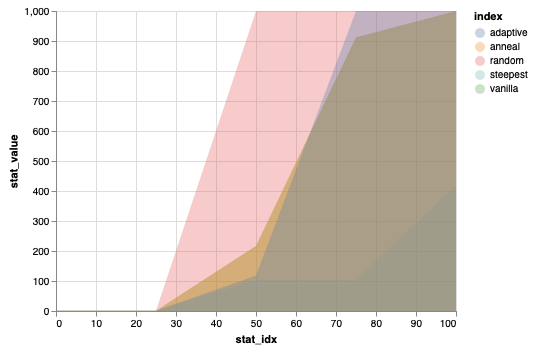

In [98]:
# Had this idea of plotting all, but the plot doesnt look useful
# table seems better
master_df2 = pd.melt(all_df.reset_index(), id_vars=['index'], value_vars=['min', '25%', '50%', '75%', 'max'], var_name='stat_name', value_name='stat_value') 
master_df2.head()
stat_idx = {
    'min': 0,
    '25%': 25,
    '50%': 50,
    '75%': 75,
    'max': 100
}
master_df2['stat_idx'] = master_df2.stat_name.apply(lambda x: stat_idx[x])
master_df2.head()

alt.Chart(master_df2).mark_area(
    opacity=0.3
).encode(
    alt.X('stat_idx'),
    alt.Y('stat_value'),
    alt.Color('index')
)

In [208]:
all_df['mean'].mean()

362.9136

In [156]:
all_df.to_csv('all_runs.csv')

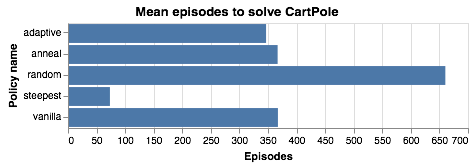

In [153]:
# Plot
alt.Chart(all_df.reset_index()).mark_bar().encode(
    alt.X("mean", title="Episodes"),
    alt.Y("index", title="Policy name")
).properties(
    title="Mean episodes to solve CartPole"
)

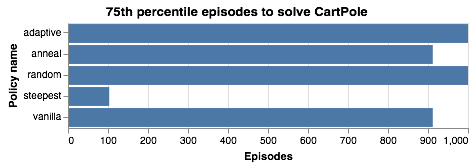

In [154]:
alt.Chart(all_df.reset_index()).mark_bar().encode(
    alt.X("75%", title="Episodes"),
    alt.Y("index", title="Policy name")
).properties(
    title="75th percentile episodes to solve CartPole"
)

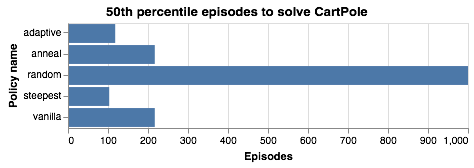

In [155]:
alt.Chart(all_df.reset_index()).mark_bar().encode(
    alt.X("50%", title="Episodes"),
    alt.Y("index", title="Policy name")
).properties(
    title="50th percentile episodes to solve CartPole"
)